In [1]:
import pm4py
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

torch.manual_seed(42)
np.random.seed(42)


d:\APM\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

LOG_FILE = "BPI_Challenge_2017.xes"
DECISION_POINT = "A_Complete"
TARGET_ACTIVITY = "A_Cancelled"

In [3]:
log = pm4py.read_xes(LOG_FILE)
df = pm4py.convert_to_dataframe(log)

if 'time:timestamp' in df.columns:
    df = df.sort_values(by=['time:timestamp', 'case:concept:name'])

# Find the column names
cols = df.columns.tolist()
score_col = next((c for c in cols if 'Credit' in c or 'score' in c.lower()), None)
amount_col = next((c for c in cols if 'Amount' in c or 'amount' in c.lower()), None)
print(f"Detected Credit Column: '{score_col}'")
print(f"Detected Amount Column: '{amount_col}'")




d:\APM\.venv\lib\site-packages\pm4py\utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")
d:\APM\.venv\lib\site-packages\pm4py\util\dt_parsing\parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
parsing log, completed traces :: 100%|██████████| 31509/31509 [01:10<00:00, 448.14it/s]


Detected Credit Column: 'CreditScore'
Detected Amount Column: 'case:RequestedAmount'


In [4]:
df.head(20)

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,statechange,User_1,A_Concept,Application,ApplState_642383566,complete,2016-01-01 09:52:36.413000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,Created,User_1,A_Create Application,Application,Application_1691306052,complete,2016-01-01 10:16:11.500000+00:00,Home improvement,New credit,Application_1691306052,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,statechange,User_1,A_Submitted,Application,ApplState_284636842,complete,2016-01-01 10:16:11.549000+00:00,Home improvement,New credit,Application_1691306052,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,Created,User_1,W_Handle leads,Workflow,Workitem_831373279,schedule,2016-01-01 10:16:11.740000+00:00,Home improvement,New credit,Application_1691306052,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,Deleted,User_1,W_Handle leads,Workflow,Workitem_1299098074,withdraw,2016-01-01 10:17:31.573000+00:00,Home improvement,New credit,Application_1691306052,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#grouping by caseid here application_id
case_groups = df.groupby("case:concept:name")
data_rows = []
labels = []
case_ids = []
is_train = []  # Track train/test for each case

# --- TEMPORAL SPLIT SETUP ---
# Get case start/end times
case_times = df.groupby("case:concept:name")["time:timestamp"].agg(["min", "max"])
case_times.columns = ["start", "end"]

# Cutoff chosen to balance train/test size while excluding cases that span both periods
CUTOFF_DATE = pd.Timestamp("2016-11-01", tz="UTC")

# Split: train = END before cutoff, test = START after cutoff, exclude = spans cutoff
train_cases = set(case_times[case_times["end"] < CUTOFF_DATE].index)
test_cases = set(case_times[case_times["start"] >= CUTOFF_DATE].index)
excluded_cases = set(case_times.index) - train_cases - test_cases

print(f"Temporal split using cutoff: {CUTOFF_DATE.date()}")
print(f"  Train (end < cutoff):    {len(train_cases)} ({100*len(train_cases)/len(case_times):.1f}%)")
print(f"  Test (start >= cutoff):  {len(test_cases)} ({100*len(test_cases)/len(case_times):.1f}%)")
print(f"  Excluded (spans cutoff): {len(excluded_cases)} ({100*len(excluded_cases)/len(case_times):.1f}%)")

# Build vocabulary only from training cases
train_activities = df[df["case:concept:name"].isin(train_cases)]["concept:name"].unique()
act_to_int = {act: i for i, act in enumerate(train_activities)}

# Process only train and test cases (exclude spanning cases)
valid_cases = train_cases | test_cases

for case_id in tqdm(valid_cases):
    group = case_groups.get_group(case_id)
    group = group.sort_values("time:timestamp")
    events = group["concept:name"].tolist()
    timestamps = group["time:timestamp"].tolist()

    # Check Decision Point
    if DECISION_POINT not in events:
        continue

    split_idx = events.index(DECISION_POINT)
    visible_events = events[:split_idx+1]
    
    # Label - with proper handling for ambiguous cases
    future_events_set = set(events[split_idx+1:])
    
    # Include O_Refused with A_Cancelled as negative outcomes
    has_cancelled = "A_Cancelled" in future_events_set or "O_Refused" in future_events_set
    has_accepted = "O_Accepted" in future_events_set

    if has_cancelled and not has_accepted:
        label = 1   # Cancelled/Refused
    elif has_accepted and not has_cancelled:
        label = 0   # Accepted
    else:
        continue    # Skip neither or both outcomes

    feature_vector = []

    # --- Credit Score ---
    current_credit = 0.0
    if score_col:
        visible_values = group.iloc[:split_idx+1][score_col]
        valid_values = visible_values.dropna()
        if not valid_values.empty:
            current_credit = float(valid_values.iloc[-1])
    feature_vector.append(current_credit)

    # --- Offer Count ---
    offer_count = visible_events.count("O_Create Offer")
    feature_vector.append(float(offer_count))

    # --- Processing Time ---
    start_time = timestamps[0]
    decision_time = timestamps[split_idx]
    duration_days = (decision_time - start_time).total_seconds() / 86400.0
    feature_vector.append(duration_days)

    # --- Amount ---
    current_amount = 0.0
    if amount_col:
        visible_values = group.iloc[:split_idx+1][amount_col]
        valid_values = visible_values.dropna()
        if not valid_values.empty:
            current_amount = float(valid_values.iloc[-1])
    feature_vector.append(current_amount)

    # Bag of words
    bow_vector = [0] * len(train_activities)
    for act in visible_events:
        if act in act_to_int:
            bow_vector[act_to_int[act]] += 1
    feature_vector.extend(bow_vector)

    data_rows.append(feature_vector)
    labels.append(label)
    case_ids.append(case_id)
    is_train.append(case_id in train_cases)

X = np.array(data_rows)
y = np.array(labels)
case_ids = np.array(case_ids)
is_train = np.array(is_train)

print(f"\nDataset Ready. Total cases: {len(X)}")
print(f"  Accepted: {len(y) - y.sum()}, Cancelled/Refused: {y.sum()}")




Temporal split using cutoff: 2016-11-01
  Train (end < cutoff):    24462 (77.6%)
  Test (start >= cutoff):  5042 (16.0%)
  Excluded (spans cutoff): 2005 (6.4%)


100%|██████████| 29504/29504 [00:33<00:00, 873.28it/s] 



Dataset Ready. Total cases: 29243
  Accepted: 16336, Cancelled/Refused: 12907


In [6]:
# --- Export Train/Test to CSV ---
feature_columns = ['CreditScore', 'OfferCount', 'ProcessingTime', 'Amount'] + \
                  [f'freq_{act}' for act in act_to_int.keys()]

train_df = pd.DataFrame(X[is_train], columns=feature_columns)
train_df.insert(0, 'CaseID', case_ids[is_train])
train_df['Label'] = y[is_train]
train_df.to_csv('train_data.csv', index=False)

test_df = pd.DataFrame(X[~is_train], columns=feature_columns)
test_df.insert(0, 'CaseID', case_ids[~is_train])
test_df['Label'] = y[~is_train]
test_df.to_csv('test_data.csv', index=False)

print(f"Exported train_data.csv ({len(train_df)} rows) and test_data.csv ({len(test_df)} rows)")

Exported train_data.csv (24332 rows) and test_data.csv (4911 rows)



Credit Score
------------
Cancelled     : mean = 0.00, median = 0.00
Accepted      : mean = 610.19, median = 841.00
Correlation with cancellation: -0.686


C:\Users\20220776\AppData\Local\Temp\ipykernel_15876\249875625.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


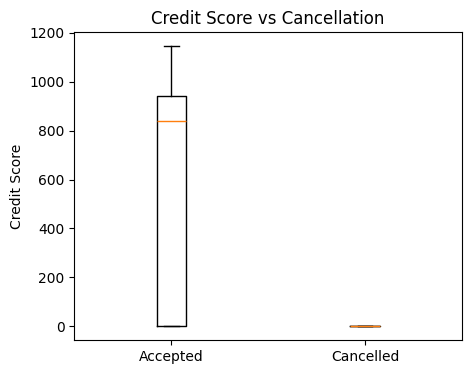


Offer Count
-----------
Cancelled     : mean = 1.14, median = 1.00
Accepted      : mean = 1.11, median = 1.00
Correlation with cancellation: 0.033


C:\Users\20220776\AppData\Local\Temp\ipykernel_15876\249875625.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


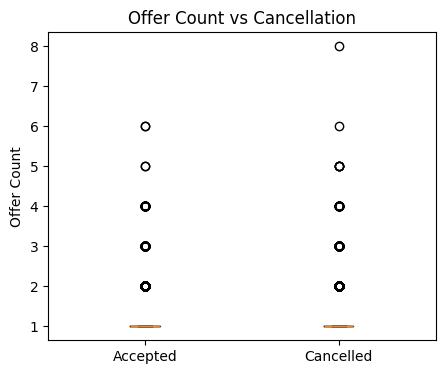


Processing Time (days)
----------------------
Cancelled     : mean = 1.73, median = 1.00
Accepted      : mean = 1.38, median = 0.85
Correlation with cancellation: 0.067


C:\Users\20220776\AppData\Local\Temp\ipykernel_15876\249875625.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


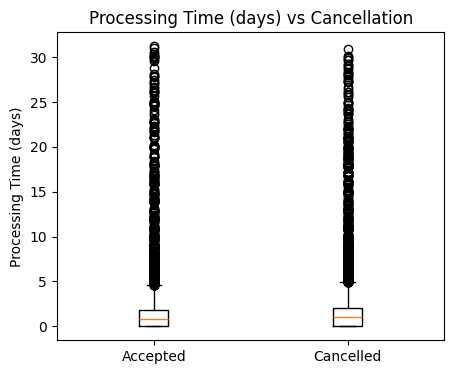

C:\Users\20220776\AppData\Local\Temp\ipykernel_15876\249875625.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(



Amount
------
Cancelled     : mean = 15693.95, median = 10000.00
Accepted      : mean = 16419.36, median = 15000.00
Correlation with cancellation: -0.023


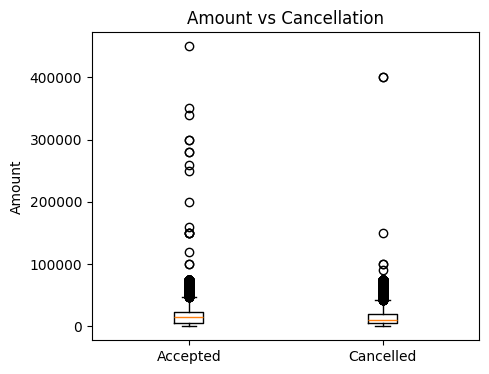

In [7]:
# ---------------------------------------------
# Feature-wise analysis vs Cancellation
# Uses EXISTING variables ONLY: X, y
# ---------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

feature_info = {
    0: "Credit Score",
    1: "Offer Count",
    2: "Processing Time (days)",
    3: "Amount"
}

cancelled = (y == 1)
not_cancelled = (y == 0)

for idx, name in feature_info.items():
    feature = X[:, idx]

    print(f"\n{name}")
    print("-" * len(name))
    print(f"Cancelled     : mean = {feature[cancelled].mean():.2f}, "
          f"median = {np.median(feature[cancelled]):.2f}")
    print(f"Accepted      : mean = {feature[not_cancelled].mean():.2f}, "
          f"median = {np.median(feature[not_cancelled]):.2f}")

    corr = np.corrcoef(feature, y)[0, 1]
    print(f"Correlation with cancellation: {corr:.3f}")

    plt.figure(figsize=(5,4))
    plt.boxplot(
        [feature[not_cancelled], feature[cancelled]],
        labels=["Accepted", "Cancelled"]
    )
    plt.title(f"{name} vs Cancellation")
    plt.ylabel(name)
    plt.show()


In [8]:
# ---------------------------------------------
# BoW Activity-wise correlation with Cancellation
# Uses EXISTING variables: X, y, train_activities, act_to_int
# ---------------------------------------------
bow_start_idx = 4   # after CreditScore, OfferCount, ProcessingTime, Amount
bow_end_idx = bow_start_idx + len(train_activities)

bow_X = X[:, bow_start_idx:bow_end_idx]

activity_corrs = []

for act, act_idx in act_to_int.items():
    activity_counts = bow_X[:, act_idx]
    corr = np.corrcoef(activity_counts, y)[0, 1]
    activity_corrs.append((act, corr))

activity_corr_df = pd.DataFrame(
    activity_corrs,
    columns=["Activity", "Correlation_with_Cancellation"]
).sort_values(by="Correlation_with_Cancellation", ascending=False)

print("\nActivities most associated with Cancellation:")
print(activity_corr_df.head(10))

print("\nActivities most associated with Acceptance:")
print(activity_corr_df.tail(10))



Activities most associated with Cancellation:
                    Activity  Correlation_with_Cancellation
1                A_Submitted                       0.146492
2             W_Handle leads                       0.145501
3     W_Complete application                       0.057264
12  O_Sent (mail and online)                       0.041900
7                  O_Created                       0.032867
6             O_Create Offer                       0.032867
23  W_Assess potential fraud                       0.002048
11               O_Cancelled                      -0.003472
8       O_Sent (online only)                      -0.005318
24   W_Shortened completion                       -0.007503

Activities most associated with Acceptance:
                   Activity  Correlation_with_Cancellation
13   W_Validate application                            NaN
14             A_Validating                            NaN
15  W_Call incomplete files                            NaN
16          

d:\APM\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\APM\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Evidence of why do the above features make sense? For acceptance we see Credit Score and Amount . For cancellations we see processing time and offer count.

Credit Score
1) A strong negative correlation (-0.654):
2) Higher credit score → much lower probability of cancellation

3) Cases without a recorded credit score are much more likely to be cancelled.

Offer Count
1) Offer count alone has very limited explanatory power for cancellation.
2) Receiving multiple offers is slightly more common among cancelled cases, but the effect is weak and noisy

3) Offer count by itself is not a strong predictor

Loan Amount
1) Loan amount shows a very weak negative association with cancellation. 
2) Can contribute to the risk
3) More loan amt lesser cancellations by the customer.

3) Cancelled cases tend to have slightly lower loan amounts on average, but the distributions overlap substantially, indicating that amount alone is not a strong predictor of cancellation.

Processing Time
1) Processing time alone does not determine cancellation, but it contributes to the risk.
2) Both groups show many high-duration outliers (extending up to ~30 days).
3) Long delays are more frequently associated with cancellation, even though they are not exclusive to it.

4) Cancelled cases generally exhibit longer processing times than non-cancelled cases, as indicated by a higher median and an upward shift in the distribution. While there is considerable overlap between the two groups, prolonged processing time appears to be associated with an increased likelihood of cancellation.

This way I take O_Accepted (leading to A_pending) and A_Cancelled (leading to O_Cancelled) as prediction setup 
Credit Score ok.
Processing Time weak.
Amount and Count of Offers->very weak

In [9]:
# Train/Test Split
X_train_raw = X[is_train]
X_test_raw = X[~is_train]
y_train = y[is_train]
y_test = y[~is_train]
test_case_ids = case_ids[~is_train]

print(f"Training set: {len(X_train_raw)} cases (ended before 2016-11-01)")
print(f"Test set: {len(X_test_raw)} cases (started after 2016-11-01)")
print(f"Train class distribution: Accepted={len(y_train)-y_train.sum()}, Cancelled={y_train.sum()}")
print(f"Test class distribution: Accepted={len(y_test)-y_test.sum()}, Cancelled={y_test.sum()}")

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)


Training set: 24332 cases (ended before 2016-11-01)
Test set: 4911 cases (started after 2016-11-01)
Train class distribution: Accepted=13642, Cancelled=10690
Test class distribution: Accepted=2694, Cancelled=2217


In [10]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
baseline_acc = dummy.score(X_test, y_test)
print(f"\nNaive Baseline (Majority Class): {baseline_acc:.4f}")



Naive Baseline (Majority Class): 0.5486


In [11]:
# Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

# Model
model = nn.Sequential(
    nn.Linear(X.shape[1], 128), 
    nn.ReLU(),
    nn.Dropout(0.3),            
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1)
)

# Class Weights
count_0 = len(y_train) - y_train.sum()
count_1 = y_train.sum()
pos_weight = torch.tensor([count_0 / count_1]) 

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) 

print("Training Neural Network...")
dataset = TensorDataset(X_train_t, y_train_t)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

model.train()
loss_history = []
epochs = 50 # Give it enough time to learn
for epoch in range(epochs): 
    epoch_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss / len(loader))
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_history[-1]:.4f}")


Training Neural Network...
Epoch 10/50, Loss: 0.3736
Epoch 20/50, Loss: 0.3705
Epoch 30/50, Loss: 0.3694
Epoch 40/50, Loss: 0.3683
Epoch 50/50, Loss: 0.3675



=== RESULTS ===
Model Accuracy: 0.8420
Improvement over Baseline: 29.34%

Classification Report:
               precision    recall  f1-score   support

    Accepted       0.95      0.75      0.84      2694
   Cancelled       0.76      0.95      0.84      2217

    accuracy                           0.84      4911
   macro avg       0.85      0.85      0.84      4911
weighted avg       0.86      0.84      0.84      4911



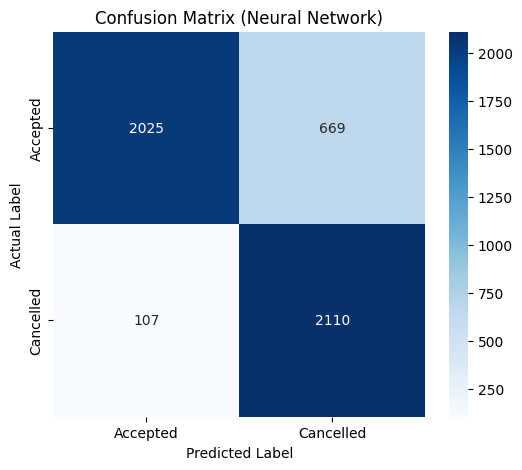

In [12]:
model.eval()
with torch.no_grad():
    logits = model(X_test_t).numpy()
    y_pred_probs = 1 / (1 + np.exp(-logits))  # Apply sigmoid manually
    y_pred = (y_pred_probs > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
print(f"\n=== RESULTS ===")
print(f"Model Accuracy: {acc:.4f}")
print(f"Improvement over Baseline: {(acc - baseline_acc)*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Accepted', 'Cancelled']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Accepted', 'Cancelled'], yticklabels=['Accepted', 'Cancelled'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix (Neural Network)")
plt.show()


In [13]:
#Behaviour of the model alone
analysis_df = pd.DataFrame({
    'CaseID': test_case_ids,
    'Actual': y_test,
    'Predicted': y_pred.flatten(),
    'Probability': y_pred_probs.flatten(),
    'CreditScore': X_test_raw[:, 0],      # feature 0
    'OfferCount': X_test_raw[:, 1],       # feature 1
    'ProcessingTime': X_test_raw[:, 2],   # feature 2 (duration_days)
    'Amount': X_test_raw[:, 3]            # feature 3
})


# Check does Credit Score matter?
avg_score_accept = analysis_df[analysis_df['Predicted'] == 0]['CreditScore'].mean()
avg_score_cancel = analysis_df[analysis_df['Predicted'] == 1]['CreditScore'].mean()

print(f"Avg Credit Score | Predicted Accepted: {avg_score_accept:.2f}")
print(f"Avg Credit Score | Predicted Cancelled    : {avg_score_cancel:.2f}")

if avg_score_accept > avg_score_cancel:
    print("-> Model associates higher credit scores with acceptance.")
else:
    print("-> Model does not strongly separate cases using credit score.")


# Check does Amount matter?
avg_offer_accept = analysis_df[analysis_df['Predicted'] == 0]['OfferCount'].mean()
avg_offer_cancel = analysis_df[analysis_df['Predicted'] == 1]['OfferCount'].mean()

print(f"\nAvg Offer Count | Predicted Accepted: {avg_offer_accept:.2f}")
print(f"Avg Offer Count | Predicted Cancelled    : {avg_offer_cancel:.2f}")

if avg_offer_cancel > avg_offer_accept:
    print("-> Model associates repeated offers with higher cancellation risk.")
else:
    print("-> Offer count plays a limited role in cancellation prediction.")

# Check does Processing Time matter?
avg_time_accept = analysis_df[analysis_df['Predicted'] == 0]['ProcessingTime'].mean()
avg_time_cancel = analysis_df[analysis_df['Predicted'] == 1]['ProcessingTime'].mean()

print(f"\nAvg Processing Time (days) | Predicted Accepted: {avg_time_accept:.2f}")
print(f"Avg Processing Time (days) | Predicted Cancelled    : {avg_time_cancel:.2f}")

if avg_time_cancel > avg_time_accept:
    print("-> Model associates longer processing times with cancellation.")
else:
    print("-> Processing time has limited influence on model predictions.")

# Check does Amount matter?
avg_amount_accept = analysis_df[analysis_df['Predicted'] == 0]['Amount'].mean()
avg_amount_cancel = analysis_df[analysis_df['Predicted'] == 1]['Amount'].mean()

print(f"\nAvg Amount | Predicted Accepted: {avg_amount_accept:.2f}")
print(f"Avg Amount | Predicted Cancelled    : {avg_amount_cancel:.2f}")

if avg_amount_accept > avg_amount_cancel:
    print("-> Model associates higher amounts with acceptance.")
else:
    print("-> Model is more conservative for higher amounts.")


Avg Credit Score | Predicted Accepted: 770.46
Avg Credit Score | Predicted Cancelled    : 0.00
-> Model associates higher credit scores with acceptance.

Avg Offer Count | Predicted Accepted: 1.07
Avg Offer Count | Predicted Cancelled    : 1.16
-> Model associates repeated offers with higher cancellation risk.

Avg Processing Time (days) | Predicted Accepted: 1.17
Avg Processing Time (days) | Predicted Cancelled    : 1.36
-> Model associates longer processing times with cancellation.

Avg Amount | Predicted Accepted: 17933.59
Avg Amount | Predicted Cancelled    : 18505.58
-> Model is more conservative for higher amounts.


In [14]:
#Actual Behaviour vs Predicted Behaviour and Error Analysis
actual_summary = analysis_df.groupby('Actual')[[
    'CreditScore', 'OfferCount', 'ProcessingTime', 'Amount'
]].mean()

print("ACTUAL OUTCOME (0 = Accepted, 1 = Cancelled)")
print(actual_summary)
pred_summary = analysis_df.groupby('Predicted')[[
    'CreditScore', 'OfferCount', 'ProcessingTime', 'Amount'
]].mean()

print("\nMODEL PREDICTIONS (0 = Predict Accepted, 1 = Predict Cancelled)")
print(pred_summary)
analysis_df['ErrorType'] = 'Correct'

analysis_df.loc[
    (analysis_df['Actual'] == 1) & (analysis_df['Predicted'] == 0),
    'ErrorType'
] = 'False Negative'   # Missed cancellation

analysis_df.loc[
    (analysis_df['Actual'] == 0) & (analysis_df['Predicted'] == 1),
    'ErrorType'
] = 'False Positive'   # Incorrect cancellation

error_summary = analysis_df.groupby('ErrorType')[[
    'CreditScore', 'OfferCount', 'ProcessingTime', 'Amount'
]].mean()

print("\nERROR ANALYSIS")
print(error_summary)


ACTUAL OUTCOME (0 = Accepted, 1 = Cancelled)
        CreditScore  OfferCount  ProcessingTime        Amount
Actual                                                       
0        609.733853    1.124722        1.168338  18427.839644
1          0.000000    1.123139        1.411678  18049.992332

MODEL PREDICTIONS (0 = Predict Accepted, 1 = Predict Cancelled)
           CreditScore  OfferCount  ProcessingTime        Amount
Predicted                                                       
0           770.461069    1.071764        1.174473  17933.593809
1             0.000000    1.164088        1.357761  18505.581504

ERROR ANALYSIS
                CreditScore  OfferCount  ProcessingTime        Amount
ErrorType                                                            
Correct          397.248609    1.100605        1.305697  17946.905683
False Negative     0.000000    1.046729        1.096314  18882.242991
False Positive     0.000000    1.281016        1.137268  20075.602392


In [15]:
# Error Analysis based on Activity Frequency
# Uses bow features (activity counts) from X_test_raw

bow_start_idx = 4  # after CreditScore, OfferCount, ProcessingTime, Amount
bow_end_idx = bow_start_idx + len(train_activities)

# Extract BoW features for test set
bow_test = X_test_raw[:, bow_start_idx:bow_end_idx]

# Add activity frequency columns to analysis_df
for act, act_idx in act_to_int.items():
    analysis_df[f'freq_{act}'] = bow_test[:, act_idx]

# Get activity columns
activity_cols = [f'freq_{act}' for act in act_to_int.keys()]

print("ERROR ANALYSIS BASED ON ACTIVITY FREQUENCY")
print("="*60)

# Group by ErrorType and calculate mean activity frequencies
error_activity_summary = analysis_df.groupby('ErrorType')[activity_cols].mean()

# Transpose for better readability and sort by difference between error types
error_activity_summary_T = error_activity_summary.T
error_activity_summary_T.columns = ['Correct', 'False Negative', 'False Positive']

# Calculate difference: activities that differ most between correct and errors
error_activity_summary_T['FN_diff'] = error_activity_summary_T['False Negative'] - error_activity_summary_T['Correct']
error_activity_summary_T['FP_diff'] = error_activity_summary_T['False Positive'] - error_activity_summary_T['Correct']

print("\nActivities with HIGHEST frequency in FALSE NEGATIVES (missed cancellations):")
fn_sorted = error_activity_summary_T.sort_values('FN_diff', ascending=False)
print(fn_sorted[['Correct', 'False Negative', 'FN_diff']].head(10))

print("\nActivities with HIGHEST frequency in FALSE POSITIVES (incorrect cancellation predictions):")
fp_sorted = error_activity_summary_T.sort_values('FP_diff', ascending=False)
print(fp_sorted[['Correct', 'False Positive', 'FP_diff']].head(10))

print("\nActivities with LOWEST frequency in FALSE NEGATIVES:")
print(fn_sorted[['Correct', 'False Negative', 'FN_diff']].tail(5))

print("\nActivities with LOWEST frequency in FALSE POSITIVES:")
print(fp_sorted[['Correct', 'False Positive', 'FP_diff']].tail(5))


ERROR ANALYSIS BASED ON ACTIVITY FREQUENCY

Activities with HIGHEST frequency in FALSE NEGATIVES (missed cancellations):
                                Correct  False Negative   FN_diff
freq_W_Complete application    4.812576        6.700935  1.888359
freq_W_Assess potential fraud  0.010157        0.046729  0.036572
freq_A_Create Application      1.000000        1.000000  0.000000
freq_A_Accepted                1.000000        1.000000  0.000000
freq_A_Concept                 1.000000        1.000000  0.000000
freq_A_Complete                1.000000        1.000000  0.000000
freq_A_Validating              0.000000        0.000000  0.000000
freq_W_Call after offers       2.000000        2.000000  0.000000
freq_W_Call incomplete files   0.000000        0.000000  0.000000
freq_A_Pending                 0.000000        0.000000  0.000000

Activities with HIGHEST frequency in FALSE POSITIVES (incorrect cancellation predictions):
                                Correct  False Positive   FP_